In [1]:
# !pip3 install medpy -i https://pypi.tuna.tsinghua.edu.cn/simple
# !pip3 install nibabel -i https://pypi.tuna.tsinghua.edu.cn/simple
# !pip3 install pynrrd -i https://pypi.tuna.tsinghua.edu.cn/simple

# pip3 install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# cd dataloaders
# !python3 la_heart_processing.py

In [3]:
# !cd ../code
# !python3 train_VNet_CTM.py --batch_size 8 --gpu "3"  #,5,6,7"

In [4]:
# !python3 test_VNet_CTM.py --gpu '3'

## 后处理

### dice的violin图\箱图

,Unnamed: 0,dice_bg,dice_dura,dice_SC
0,B1756747,0.994013,0.916159,0.888178
1,1735950,0.994918,0.924542,0.830886
2,B1632110,0.995968,0.932246,0.928131
3,b930124,0.993516,0.922339,0.811209
4,B1536553,0.993693,0.946402,0.914213


,dice,category,patient
0,0.994013,bg,B1756747
1,0.994918,bg,1735950
2,0.995968,bg,B1632110
3,0.993516,bg,b930124
4,0.993693,bg,B1536553


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 29.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


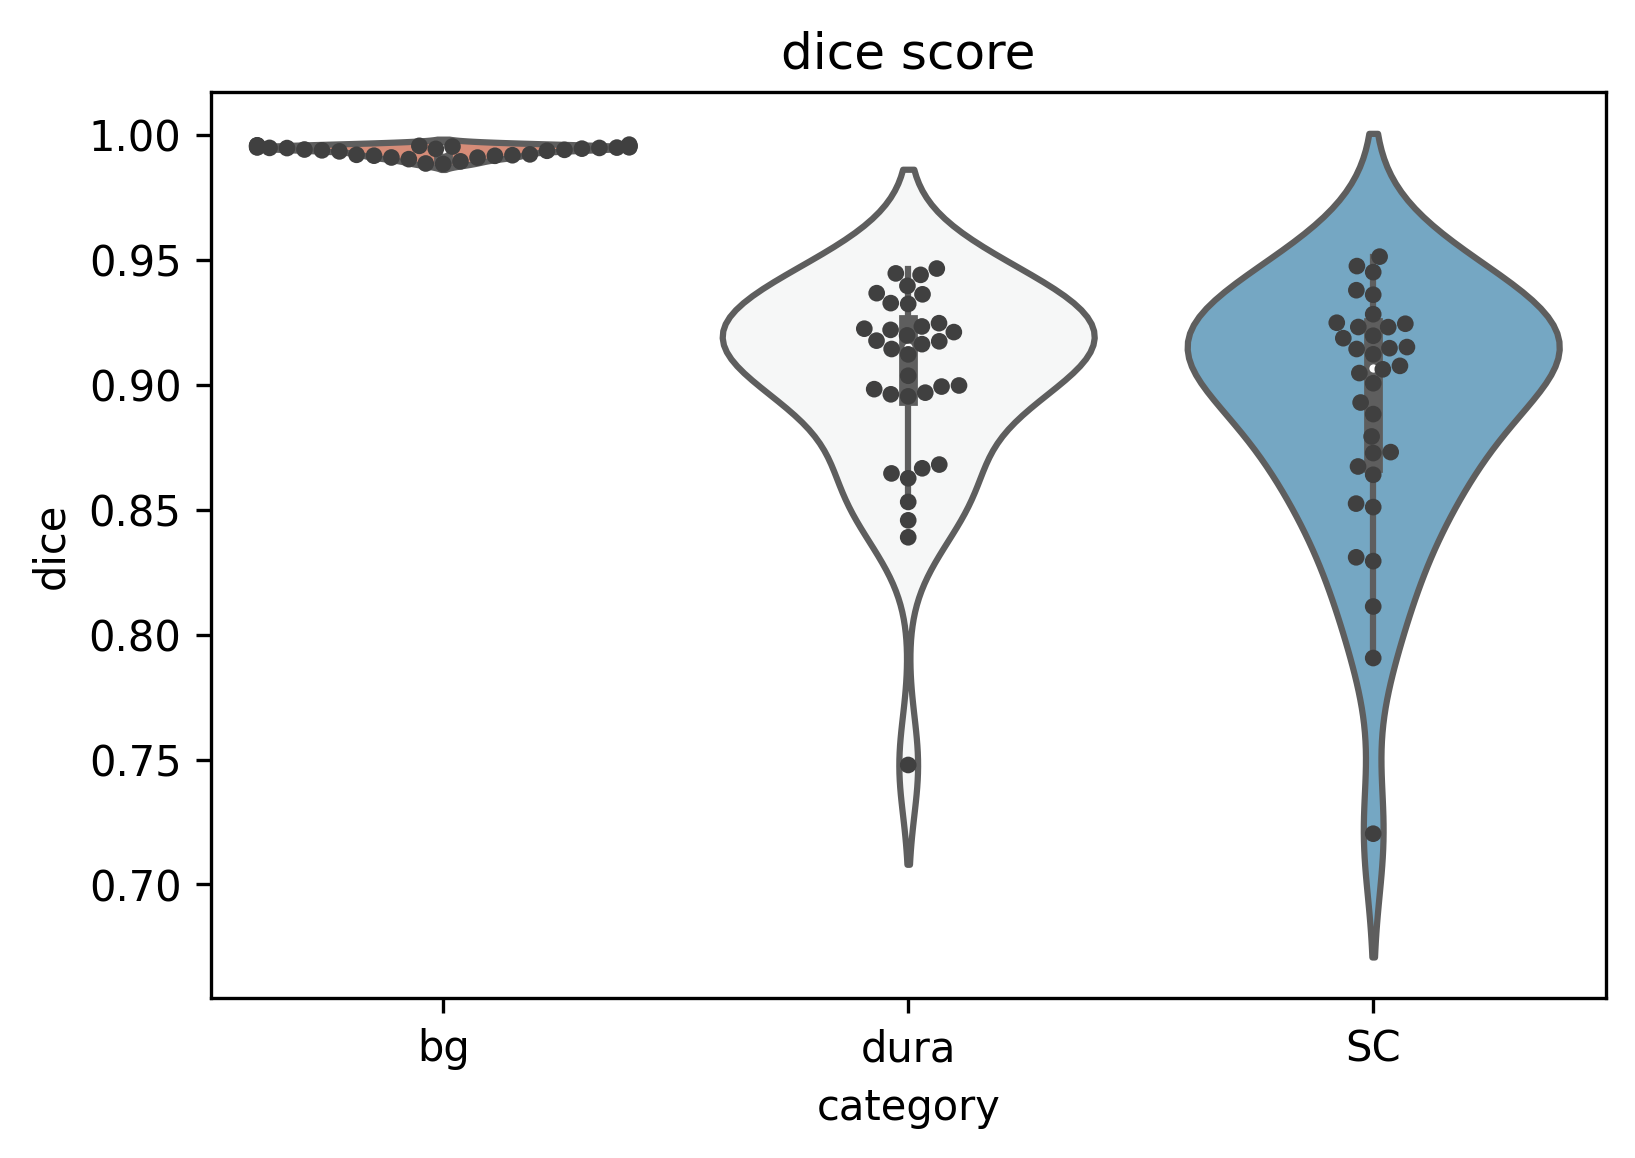

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

filename = "../model/prediction/vnet_supervisedonly_dp_post/metrics_test_set.csv"
results_raw = pd.read_csv(filename)
display(results_raw.head())

# 删除异常样本
results_raw = results_raw.drop(results_raw[results_raw['dice_SC']<0.65].index)

# 重新整理数据表,以便适应sns.violinplot
proc_df = pd.DataFrame(columns=['dice','category','patient'])
proc_df = pd.DataFrame(columns=['dice','category','patient'])
proc_df.dice = pd.to_numeric(pd.concat([results_raw.dice_bg,results_raw.dice_dura,results_raw.dice_SC]))
proc_df.category = ['bg']*len(results_raw)+['dura']*len(results_raw)+['SC']*len(results_raw)
proc_df.patient = pd.concat([results_raw['Unnamed: 0'],results_raw['Unnamed: 0'],results_raw['Unnamed: 0']]).values
proc_df.dice = proc_df.dice.astype('float')
proc_df.category = proc_df.category.astype('category')

# https://cloud.tencent.com/developer/article/1486970
display(proc_df.head())
plt.figure(dpi=300)
ax = sns.violinplot( data=proc_df, x='category', y='dice', order=['bg','dura','SC'],scale="width",palette = 'RdBu' )
ax = sns.swarmplot(data=proc_df, x='category', y='dice', order=['bg','dura','SC'], color=".25", size=4)
# 添加图形标题
plt.title('dice score')
# 保存图片
filename=os.path.join(results_dir,'voilinplot of pred dice-score on test-set.png')
plt.savefig(filename)
# 显示图形
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 20.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


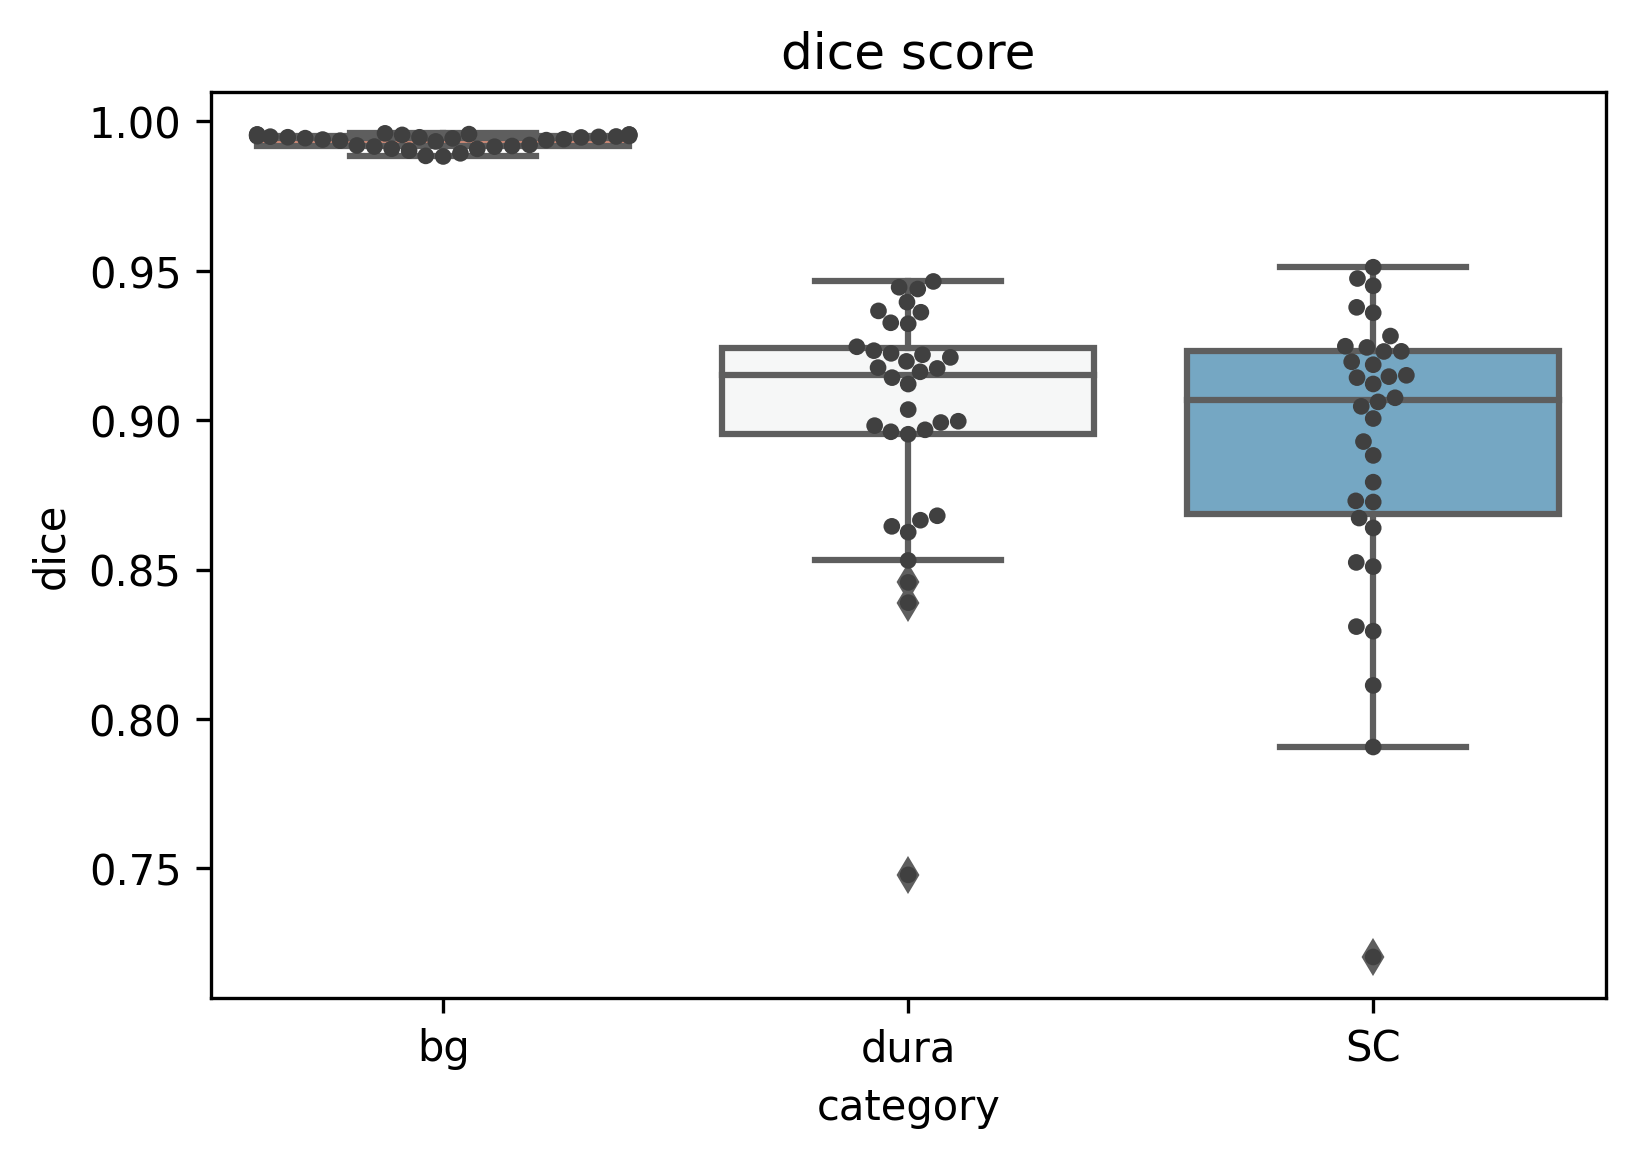

In [22]:
plt.figure(dpi=300)
ax = sns.boxplot(data=proc_df, x='category', y='dice', order=['bg','dura','SC'], palette = 'RdBu')
ax = sns.swarmplot(data=proc_df, x='category', y='dice', order=['bg','dura','SC'], color=".25", size=4)
# 添加图形标题
plt.title('dice score')
# 保存图片
filename=os.path.join(results_dir,'boxplot of pred dice-score on test-set.png')
plt.savefig(filename)
# 显示图形
plt.show()

### 画自动分割mask对比图

In [7]:
patients = results_raw['Unnamed: 0'].values
display(patients)

array(['B1756747', '1735950', 'B1632110', 'b930124', 'B1536553',
       'B928647', '1182723', '1261721', '1352900', 'B1182723', '643486',
       'b936932-dingzi', 'B1694915', 'B1006763', '1678746', 'B1424004',
       'B1328036', 'B1425167', '945286', 'b1460036-thoracic', 'B759663',
       'B1521755', '1371504', 'B1352900', 'B976555', '840383', 'B805736',
       'b1427578', '1700637-neck', 'B1330032', '1027338', '772230',
       'B617407', '820056'], dtype=object)

In [8]:
results_dir = "../model/prediction/vnet_supervisedonly_dp_post"
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

import torch
import torchvision
import torchvision.transforms as transforms


patients = results_raw['Unnamed: 0'].values
images = tuple()
n_case = 10
H, W = 140, 140
for patient in patients[:10]:
    image_sitk = sitk.ReadImage(os.path.join(results_dir, patient+'_img.nii.gz'))
    label_gt_sitk = sitk.ReadImage(os.path.join(results_dir, patient+'_gt.nii.gz'))
    label_pred_sitk = sitk.ReadImage(os.path.join(results_dir, patient+'_pred.nii.gz'))

    image = sitk.GetArrayFromImage(image_sitk).transpose([2,1,0])
    image = (image-image.min())/(image.max()-image.min())*255
    label_gt = sitk.GetArrayFromImage(label_gt_sitk).transpose([2,1,0])/2*255
    label_pred = sitk.GetArrayFromImage(label_pred_sitk).transpose([2,1,0])/2*255

    # 图像必须大小相同
    hmin,hmax = int((image.shape[0]-H)/2), int((image.shape[0]-H)/2+H)
    wmin,wmax = int((image.shape[1]-W)/2), int((image.shape[1]-W)/2+W)
    image = image[hmin:hmax,wmin:wmax,:]
    label_gt = label_gt[hmin:hmax,wmin:wmax,:]

    label_pred = label_pred[hmin:hmax,wmin:wmax,:]
    # case 拼接
    numd = []
    for d in range(label_gt.shape[2]):
        numd.append( len(np.where(label_gt[:,:,d].flatten()==255)[0]) )
    numd = np.array(numd)
    slice = np.where(numd==numd.max())[0][0]
#     print('slice',slice)
    images = images+(image[:,:,slice][np.newaxis,np.newaxis,:,:],
                     label_gt[:,:,slice][np.newaxis,np.newaxis,:,:], 
                     label_pred[:,:,slice][np.newaxis,np.newaxis,:,:])
images = np.concatenate(images, axis=0)
print(images.shape)
print('np.unique(images):',np.unique(images))
images = torch.tensor(images)


slice 65
slice 66
slice 65
slice 69
slice 78
slice 48
slice 58
slice 62
slice 66
slice 58
(30, 1, 140, 140)
np.unique(images): [  0.        10.063686  10.223429 ... 239.7161   241.7508   255.      ]


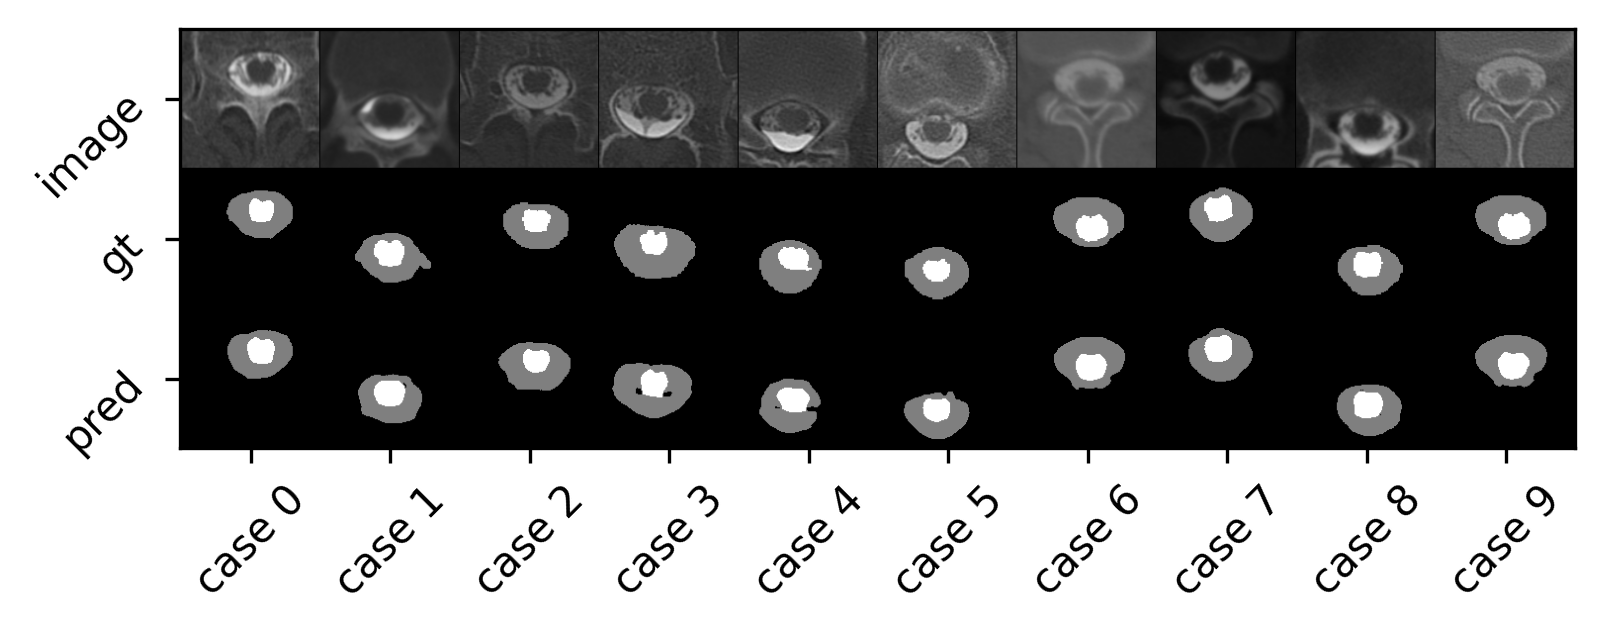

In [24]:
# functions to show an image
def imshow(img,n_case,filename=None):
    fig = plt.figure( dpi=300, frameon=False)
#     print(np.unique(img))
    npimg = img.numpy()
    npimg = np.transpose(npimg, (2, 1, 0))
#     print(npimg.shape)
    plt.imshow(npimg.astype(int),cmap='plasma')#一定要转为int
#     print(np.unique(npimg))
    xticks = [npimg.shape[1]/n_case*(i+0.5) for i in range(n_case)]
    yticks = [npimg.shape[0]/3*0.5,npimg.shape[0]/3*1.5,npimg.shape[0]/3*2.5]
    xlabels = ['case '+str(int(i)) for i in range(n_case)]
#     print(yticks)
    plt.xticks(xticks, xlabels,rotation=45) 
    plt.yticks(yticks, ['image', 'gt', 'pred'],rotation=45) 
    if filename:
        plt.savefig(filename)
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images, nrow=3, padding=1), 
       n_case=n_case,
       filename=os.path.join(results_dir,'pred_mask vs gt_mask.png')
      )
